In [2]:
import sys
sys.path.insert(1, '../')


In [3]:
import importlib
import medical_explainer
importlib.reload(medical_explainer)


<module 'medical_explainer' from '/Users/llja0112/repos/Uni-ACS/mimiciv_sepsis/../medical_explainer.py'>

In [1]:
import pandas as pd
data = pd.read_csv('mimiciv_sepsis.csv').drop(['testtrain', 'hadm_id'], axis=1)

data['gender'] = data['gender'].apply(lambda x: 1 if x == 'M' else 0)

data = pd.concat([data, pd.get_dummies(data['marital_status'], prefix='marital_status')], axis=1)
data = data.drop(['marital_status'], axis=1)

data = pd.concat([data, pd.get_dummies(data['ethnicity'], prefix='ethnicity')], axis=1)
data = data.drop(['ethnicity'], axis=1)

data = pd.concat([data, pd.get_dummies(data['insurance'], prefix='insurance')], axis=1)
data = data.drop(['insurance'], axis=1)

data = pd.concat([data, pd.get_dummies(data['ed_medgp_antibiotic_hrgp'], prefix='antibiotic')], axis=1)
data = data.drop(['ed_medgp_antibiotic_hrgp'], axis=1)

In [5]:
from sklearn.model_selection import train_test_split

seed = 7

X = data.drop(['icu_adm_flag', 'hosdeath_flag'], axis=1)
y = data['icu_adm_flag']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=seed)


In [6]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(X_train)

X_train = pd.DataFrame(imp.transform(X_train), columns=X.columns)
X_test = pd.DataFrame(imp.transform(X_test), columns=X.columns)

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score

clf = RandomForestClassifier(n_estimators=140, max_depth=5, random_state=seed)
clf.fit(X_train, y_train)

roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print("ROC AUC: " + str(roc_auc))

average_precision = average_precision_score(y_test, clf.predict_proba(X_test)[:, 1])
print("Average Precision: " + str(average_precision))

accuracy = accuracy_score(y_test, clf.predict(X_test))
print("Accuracy: " + str(accuracy))

ROC AUC: 0.9028159770564068
Average Precision: 0.8259986815973044
Accuracy: 0.8573905504984829


| Step 1  ==> Calibrating model


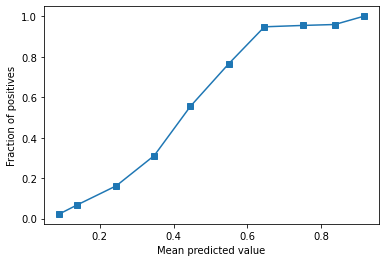

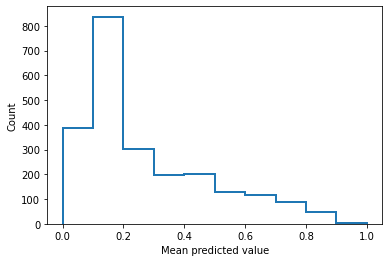

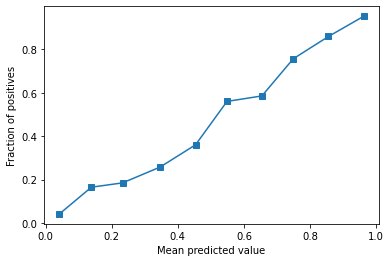

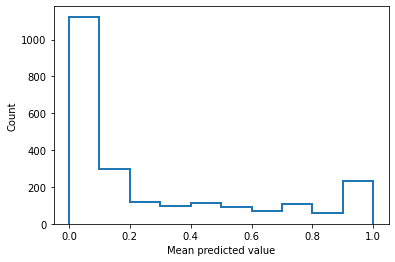

ROC AUC: 0.9028159770564068
Average Precision: 0.8259986815973044
Accuracy: 0.8573905504984829
ROC AUC: 0.9034684734240506
Average Precision: 0.8237131242288572
Accuracy: 0.871261378413524

| Step 2 ==> Calculate SHAP values

| Step 3 ==> Fit clinical score calculator
Novel fitting


Probability threshold: 0.1
Score threshold: nan

Probability threshold: 0.5
Score threshold: 46.0

Probability threshold: 0.9
Score threshold: 84.0



In [9]:
explainer = medical_explainer.explainer(
    clf, X_train, y_train, X_test, y_test)

explainer.fit(10, shap_method='tree', method='novel', calculator_threshold=0.0001)

In [10]:
explainer.shap_array_list

[[-0.14714251185779986, 0.6727651024555035],
 [0.3699890552776238, -0.10616845613093633],
 [-0.08899968320479577, 0.1854156034742193],
 [0.2657276202790669, -0.07920991307412212],
 [-0.08413417733510618, 0.16472938088636266],
 [-0.06611560164252556, 0.2995222692505376],
 [-0.0476080348621906, 0.14547156641193656],
 [0.1252044985180628, -0.050142251111458334],
 [-0.040723369496009784, 0.08441651169036085],
 [-0.036615767257849985, 0.1353321127459803]]

In [11]:
explainer.score_array_list

[array([-4., 18.]),
 array([10., -3.]),
 array([-2.,  5.]),
 array([ 7., -2.]),
 array([-2.,  4.]),
 array([-2.,  8.]),
 array([-1.,  4.]),
 array([ 3., -1.]),
 array([-1.,  2.]),
 array([-1.,  4.])]

In [12]:
explainer.variables

array(['time2bg_24hr_flag', 'edvital_sbp_min', 'edvital_resprate_max',
       'edvital_sbp_median', 'edvital_resprate_median',
       'antibiotic_a_lesse1', 'ed_a_vancomycin', 'edvital_dbp_min',
       'fbc24hr_wbc_first', 'edvital_heartrate_max'], dtype=object)

In [13]:
explainer.breakpoints_list

[[0.0, 0.18600392945867675, 1.0],
 [4.0, 94.77904167720034, 202.0],
 [12.0, 23.20815733092932, 165.0],
 [10.0, 107.3594440672566, 212.0],
 [9.5, 19.288328873237653, 62.0],
 [0.0, 0.18733640468781476, 1.0],
 [0.0, 0.2517440533286757, 1.0],
 [0.0, 49.06909158176476, 108.0],
 [0.1, 11.184271476498326, 216.3],
 [42.0, 112.66865415364775, 196.0]]

In [14]:
scores,probs,predictions = explainer.predict_calculator(X_test, 1)

In [15]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

roc_auc = roc_auc_score(y_test, probs)
print("ROC AUC: " + str(roc_auc))

average_precision = average_precision_score(y_test, probs)
print("Average Precision: " + str(average_precision))

# accuracy = accuracy_score(y_test, predictions)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: " + str(accuracy))

# print(confusion_matrix(y_test, predictions))
print(confusion_matrix(y_test, predictions))


ROC AUC: 0.8816112677018093
Average Precision: 0.7804424858688577
Accuracy: 0.8300823580407456
[[1646   33]
 [ 359  269]]


In [16]:
import numpy as np
import scipy.stats


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h


In [17]:
y_test = y_test.reset_index(drop=True)

In [18]:
from sklearn.utils import resample

auroc_array = []
auprc_array = []
accuracy_array = []

for i in range(50):
    X_test_bs = resample(X_test, n_samples=200, replace=False, stratify=y_test,
             random_state=i)
    y_test_bs = y_test[X_test_bs.index]

    scores,probs,predictions = explainer.predict_calculator(X_test_bs, 1)
    auroc = roc_auc_score(y_test_bs, probs)
    auprc = average_precision_score(y_test_bs, probs)
    accuracy = accuracy_score(y_test_bs, predictions)
    
    auroc_array.append(auroc)
    auprc_array.append(auprc)
    accuracy_array.append(accuracy)
    

print(mean_confidence_interval(auroc_array))
print(mean_confidence_interval(auprc_array))
print(mean_confidence_interval(accuracy_array))

(0.8799594114662607, 0.8713732841777914, 0.88854553875473)
(0.7719596223059608, 0.7583120408032626, 0.785607203808659)
(0.8281000000000002, 0.8224971884495883, 0.833702811550412)
